In [8]:
import tensorflow as tf
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time
from sklearn import metrics

In [9]:
def get_optimizer(optimizer_name):
    learning_rate = 0.05
    if optimizer_name == "ada":
        return tf.train.AdagradOptimizer(learning_rate=learning_rate)
    elif optimizer_name == "adam":
        return tf.train.AdamOptimizer(learning_rate=learning_rate)
    elif optimizer_name == "rms":
        return tf.train.RMSPropOptimizer(learning_rate=learning_rate)

def get_model(name, layers, dropout, wide_columns, deep_columns, model_dir="./models"):
    tf.reset_default_graph()
    shutil.rmtree(model_dir, ignore_errors=True)
    run_config = tf.estimator.RunConfig().replace(
        session_config=tf.ConfigProto(device_count={'GPU': 0}))
    if name == 'wide':
        return tf.estimator.LinearClassifier(
            model_dir=model_dir,
            feature_columns=wide_columns,
            config=run_config,
            n_classes=9
        )
    elif name == 'deep':
        return tf.estimator.DNNClassifier(
            model_dir=model_dir,
            feature_columns=deep_columns,
            hidden_units=layers,
            dropout=dropout,
            optimizer=get_optimizer("ada"),
            config=run_config,
            n_classes=9
        )
    elif name == 'wd':
        return tf.estimator.DNNLinearCombinedClassifier(
            model_dir=model_dir,
            linear_feature_columns=wide_columns,
            dnn_feature_columns=deep_columns,
            dnn_hidden_units=layers,
            dnn_optimizer=get_optimizer("ada"),
            dnn_dropout=dropout,
            config=run_config,
            n_classes=9
        )

def make_dtype(category_columns):
    dtype = {}
    for category_column in category_columns:
        dtype[category_column] = "str"
    return dtype

def df_to_dataset(dataframe, num_epochs, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('TARGET')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.repeat(num_epochs)
    ds = ds.batch(batch_size)
    return ds

def train_input_fn():
    return df_to_dataset(df_train, num_epochs)

def train_input_fn_one_epoch():
    return df_to_dataset(df_train, 1, False, 32)

def eval_input_fn():
    return df_to_dataset(df_test, 1, False, 32)

In [10]:
cat_cols = ["Well_Name", "NM_M"]
num_cols = ['Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'RELPOS']
all_cols = cat_cols + num_cols + ["TARGET"]
data_path = "datasetwithlabelencoded.csv"
df = pd.read_csv(data_path, dtype=make_dtype(cat_cols), usecols=all_cols)
# df.drop(["Formation"], axis=1, inplace=True)
df_train, df_test = train_test_split(df, test_size=0.3)

### Visualize data

In [11]:
df_source = df.copy()

In [12]:
df_source.head()

,TARGET,Well_Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,2,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,2,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,2,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,2,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [13]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['TARGET']]
    
df_source['FaciesLabels'] = df_source.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [14]:
df_source.head()

,TARGET,Well_Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,2,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,2,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,2,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,2,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,2,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


In [17]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['TARGET'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well_Name'], fontsize=14,y=0.94)
    plt.show()

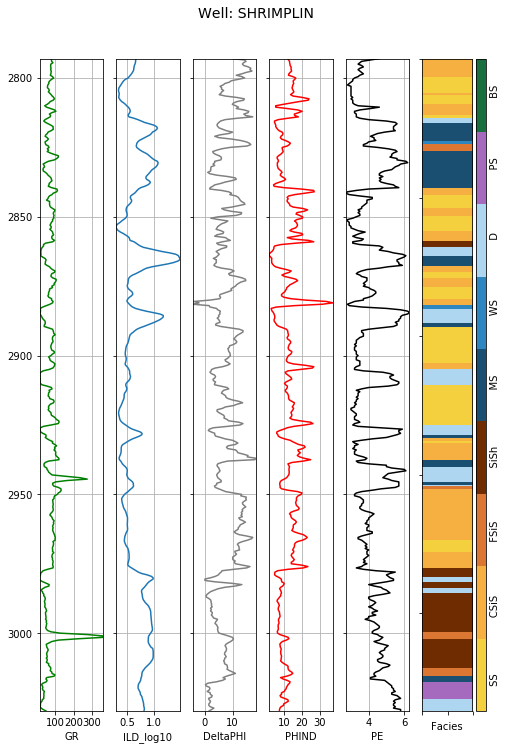

In [16]:
make_facies_log_plot(
    df_source[df_source['Well_Name'] == 'SHRIMPLIN'],
    facies_colors)

In [25]:
lb = LabelEncoder()
df_source["Well_Name_Enc"] = lb.fit_transform(df_source["Well_Name"].tolist())
df_source.head()

,TARGET,Well_Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,Well_Name_Enc
0,2,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS,7
1,2,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS,7
2,2,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS,7
3,2,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS,7
4,2,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS,7


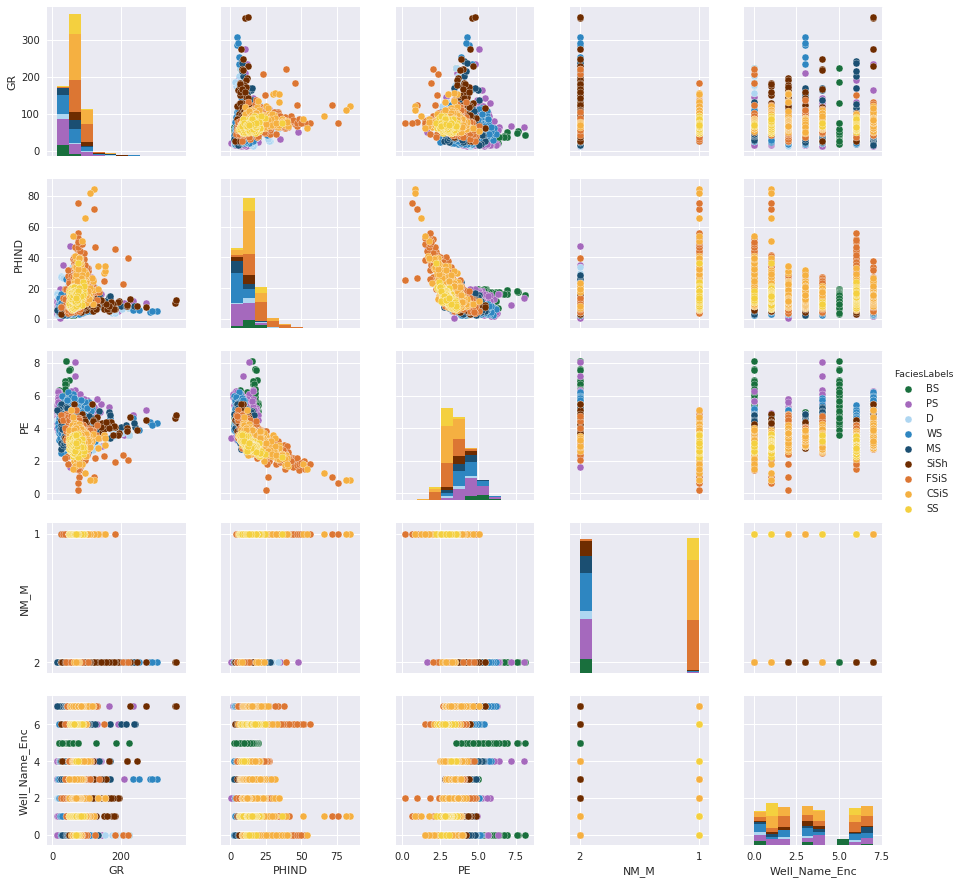

In [26]:
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(df_source.drop(['TARGET','Depth', 'RELPOS', 'ILD_log10', 'DeltaPHI', 'Well_Name'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

In [22]:
df_source.columns

Index(['TARGET', 'Well_Name', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND',
       'PE', 'NM_M', 'RELPOS', 'FaciesLabels'],
      dtype='object')

### Clean data

In [27]:
cat_col = "Well_Name"
set_values = list(df_train[cat_col].unique())
set_values.append("unknown")
print(set_values)
lb = LabelEncoder()
lb.fit(set_values)
set_values = set(set_values)
df_test[cat_col] = df_test[cat_col].apply(lambda row: row if row in set_values else "unknown")
df_train[cat_col] = lb.transform(df_train[cat_col])
df_test[cat_col] = lb.transform(df_test[cat_col])

# normalize
for num_col in num_cols:
    scaler = StandardScaler()
    df_train[num_col] = scaler.fit_transform(df_train[num_col].values.reshape(-1, 1))[:, 0]
    df_test[num_col] = scaler.transform(df_test[num_col].values.reshape(-1, 1))[:, 0]

# df_train.to_csv("train.csv")
# df_test.to_csv("test.csv")
print(df_train.head())
# make feature columns
# wide_cols = []
deep_cols = []
for num_col in num_cols:
    tmp = tf.feature_column.numeric_column(num_col)
    deep_cols.append(tmp)

well_name = tf.feature_column.embedding_column(tf.feature_column.categorical_column_with_vocabulary_list(
            "Well_Name", df_train["Well_Name"].unique().tolist()
        ), dimension=79)
nm_m = tf.feature_column.categorical_column_with_hash_bucket(
            "NM_M", hash_bucket_size=17336)
wide_cols = [well_name, nm_m]

# model config
num_epochs = 500
layers = [500, 400, 300]
optimizer = "ada"
dropout = 0.2

['NOLAN', 'SHANKLE', 'NEWBY', 'LUKE G U', 'SHRIMPLIN', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'Recruit F9', 'unknown']


/home/ntkhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ntkhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ntkhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

      TARGET  Well_Name     Depth        GR  ILD_log10  DeltaPHI     PHIND  \
2011       1          4  0.318379  0.457195  -0.272028 -0.440816 -0.537658   
493        0          6 -0.694754 -0.231868  -0.951541  0.025841  0.022203   
2533       6          3  0.257208 -1.367440   0.082143 -0.050255 -0.415108   
2449       3          3 -0.063935  0.015559   0.040961  0.463391  0.042843   
1064       1          2 -1.482321 -0.345774  -1.046261 -0.449757 -0.240958   

            PE NM_M    RELPOS  
2011 -0.297372    1 -0.891089  
493  -1.264399    1  0.435022  
2533  0.089664    2  0.665346  
2449 -0.248852    2 -0.070994  
1064 -0.925883    1 -0.472317  


### SVM

In [25]:
features = list(df_train.columns)
features.remove("TARGET")

In [26]:
features

['Well_Name',
 'Depth',
 'GR',
 'ILD_log10',
 'DeltaPHI',
 'PHIND',
 'PE',
 'NM_M',
 'RELPOS']

In [27]:
X_train = df_train[features].values
y_train = df_train["TARGET"].values

X_test = df_test[features].values
y_test = df_test["TARGET"].values

from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
from sklearn import metrics
predicted_labels = clf.predict(X_test)
print("ACC: ", metrics.accuracy_score(y_test, predicted_labels))

ACC:  0.7195876288659794


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

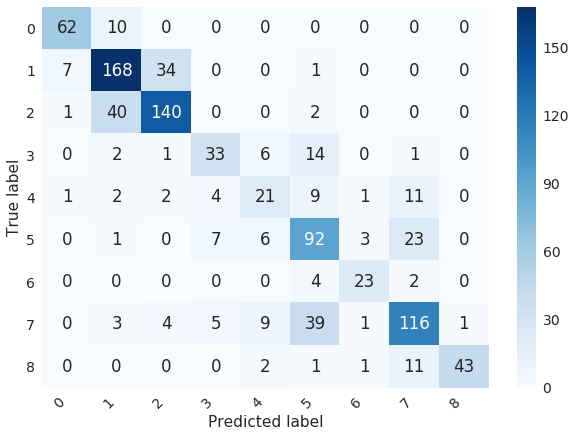

In [59]:
mx_confus = metrics.confusion_matrix(y_test, predicted_labels)
# df_confus = pd.DataFrame(mx_confus, range(9), range(9))
print_confusion_matrix(mx_confus, list(range(9)))

### Deep Model

In [13]:
# Train deep
#train
model = get_model("deep", layers, dropout, wide_cols, deep_cols)
time_start = time.time()
model.train(input_fn=train_input_fn)
time_end = time.time()


INFO:tensorflow:Using config: {'_model_dir': './models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': device_count {
  key: "GPU"
  value: 0
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f320b8256a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorfl

INFO:tensorflow:loss = 3.1549304, step = 7301 (0.169 sec)
INFO:tensorflow:global_step/sec: 581.887
INFO:tensorflow:loss = 4.0349565, step = 7401 (0.172 sec)
INFO:tensorflow:global_step/sec: 589.521
INFO:tensorflow:loss = 5.2769346, step = 7501 (0.170 sec)
INFO:tensorflow:global_step/sec: 590.334
INFO:tensorflow:loss = 7.7785916, step = 7601 (0.169 sec)
INFO:tensorflow:global_step/sec: 588.256
INFO:tensorflow:loss = 3.2506206, step = 7701 (0.170 sec)
INFO:tensorflow:global_step/sec: 585.162
INFO:tensorflow:loss = 4.324131, step = 7801 (0.171 sec)
INFO:tensorflow:global_step/sec: 593.435
INFO:tensorflow:loss = 4.7722955, step = 7901 (0.169 sec)
INFO:tensorflow:global_step/sec: 582.412
INFO:tensorflow:loss = 2.3705075, step = 8001 (0.172 sec)
INFO:tensorflow:global_step/sec: 592.073
INFO:tensorflow:loss = 5.0038323, step = 8101 (0.169 sec)
INFO:tensorflow:global_step/sec: 582.677
INFO:tensorflow:loss = 4.0839825, step = 8201 (0.172 sec)
INFO:tensorflow:global_step/sec: 584.341
INFO:tensor

INFO:tensorflow:global_step/sec: 589.186
INFO:tensorflow:loss = 1.8167326, step = 15601 (0.170 sec)
INFO:tensorflow:global_step/sec: 588.483
INFO:tensorflow:loss = 1.7450724, step = 15701 (0.170 sec)
INFO:tensorflow:global_step/sec: 585.125
INFO:tensorflow:loss = 0.8685899, step = 15801 (0.171 sec)
INFO:tensorflow:global_step/sec: 589.137
INFO:tensorflow:loss = 1.5432837, step = 15901 (0.170 sec)
INFO:tensorflow:global_step/sec: 590.066
INFO:tensorflow:loss = 2.568029, step = 16001 (0.169 sec)
INFO:tensorflow:global_step/sec: 589.982
INFO:tensorflow:loss = 2.1662939, step = 16101 (0.170 sec)
INFO:tensorflow:global_step/sec: 588.496
INFO:tensorflow:loss = 1.3737266, step = 16201 (0.170 sec)
INFO:tensorflow:global_step/sec: 585.279
INFO:tensorflow:loss = 0.57897484, step = 16301 (0.171 sec)
INFO:tensorflow:global_step/sec: 586.96
INFO:tensorflow:loss = 0.35682383, step = 16401 (0.170 sec)
INFO:tensorflow:global_step/sec: 581.916
INFO:tensorflow:loss = 4.857888, step = 16501 (0.172 sec)
I

INFO:tensorflow:loss = 2.027618, step = 23801 (0.169 sec)
INFO:tensorflow:global_step/sec: 587.847
INFO:tensorflow:loss = 2.9172106, step = 23901 (0.170 sec)
INFO:tensorflow:global_step/sec: 588.559
INFO:tensorflow:loss = 3.4906464, step = 24001 (0.170 sec)
INFO:tensorflow:global_step/sec: 578.152
INFO:tensorflow:loss = 1.1343945, step = 24101 (0.173 sec)
INFO:tensorflow:global_step/sec: 589.643
INFO:tensorflow:loss = 0.50298345, step = 24201 (0.170 sec)
INFO:tensorflow:global_step/sec: 589.49
INFO:tensorflow:loss = 1.0346904, step = 24301 (0.170 sec)
INFO:tensorflow:global_step/sec: 586.513
INFO:tensorflow:loss = 1.1457671, step = 24401 (0.171 sec)
INFO:tensorflow:global_step/sec: 594.74
INFO:tensorflow:loss = 0.5831343, step = 24501 (0.168 sec)
INFO:tensorflow:global_step/sec: 580.894
INFO:tensorflow:loss = 0.07713482, step = 24601 (0.172 sec)
INFO:tensorflow:global_step/sec: 585.547
INFO:tensorflow:loss = 0.74027735, step = 24701 (0.171 sec)
INFO:tensorflow:global_step/sec: 584.971


INFO:tensorflow:loss = 0.51120555, step = 32001 (0.172 sec)
INFO:tensorflow:global_step/sec: 586.438
INFO:tensorflow:loss = 1.0242184, step = 32101 (0.171 sec)
INFO:tensorflow:global_step/sec: 590.687
INFO:tensorflow:loss = 0.39474913, step = 32201 (0.169 sec)
INFO:tensorflow:global_step/sec: 590.993
INFO:tensorflow:loss = 2.4666867, step = 32301 (0.169 sec)
INFO:tensorflow:global_step/sec: 584.617
INFO:tensorflow:loss = 1.1718024, step = 32401 (0.171 sec)
INFO:tensorflow:global_step/sec: 590.868
INFO:tensorflow:loss = 1.7381526, step = 32501 (0.169 sec)
INFO:tensorflow:global_step/sec: 586.915
INFO:tensorflow:loss = 2.3612921, step = 32601 (0.170 sec)
INFO:tensorflow:global_step/sec: 585.479
INFO:tensorflow:loss = 0.4330594, step = 32701 (0.171 sec)
INFO:tensorflow:global_step/sec: 581.291
INFO:tensorflow:loss = 0.2015848, step = 32801 (0.172 sec)
INFO:tensorflow:global_step/sec: 578.954
INFO:tensorflow:loss = 3.6980228, step = 32901 (0.173 sec)
INFO:tensorflow:global_step/sec: 584.10

In [14]:
res_train = {}
res_test = {}

y_train_real = df_train["TARGET"].values
y_test_real = df_test["TARGET"].values

test_pred_gens = model.predict(input_fn=eval_input_fn)
results = model.evaluate(input_fn=eval_input_fn)
res_train['loss'] = results.get('average_loss')
y_test_pred = []
y_test_classes = []
for item in test_pred_gens:
    y_test_pred.append(item['probabilities'][1])
    y_test_classes.append(item['class_ids'][0])

train_pred_gens = model.predict(input_fn=train_input_fn_one_epoch)
y_train_pred = []
y_train_classes = []
for item in train_pred_gens:
    y_train_pred.append(item['probabilities'][1])
    y_train_classes.append(item['class_ids'][0])

res_test['acc'] = round(metrics.accuracy_score(y_test_real, y_test_classes), 2)
res_train['acc'] = round(metrics.accuracy_score(y_train_real, y_train_classes), 2)
print(res_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-02-20T04:22:33Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/model.ckpt-35344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-02-20-04:22:33
INFO:tensorflow:Saving dict for global step 35344: accuracy = 0.7515464, average_loss = 1.9486119, global_step = 35344, loss = 60.97269
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 35344: ./models/model.ckpt-35344
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/model.ckpt-35344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow

### Wide Deep Model

In [28]:
model = get_model("wd", layers, dropout, wide_cols, deep_cols)
time_start = time.time()
model.train(input_fn=train_input_fn)
time_end = time.time()

INFO:tensorflow:Using config: {'_model_dir': './models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': device_count {
  key: "GPU"
  value: 0
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f63203a5c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate

INFO:tensorflow:global_step/sec: 570.497
INFO:tensorflow:loss = 6.3459554, step = 5401 (0.175 sec)
INFO:tensorflow:global_step/sec: 576.734
INFO:tensorflow:loss = 4.9461465, step = 5501 (0.173 sec)
INFO:tensorflow:global_step/sec: 573.723
INFO:tensorflow:loss = 6.4375978, step = 5601 (0.174 sec)
INFO:tensorflow:global_step/sec: 570.89
INFO:tensorflow:loss = 5.976797, step = 5701 (0.175 sec)
INFO:tensorflow:global_step/sec: 571.672
INFO:tensorflow:loss = 5.2367177, step = 5801 (0.175 sec)
INFO:tensorflow:global_step/sec: 578.141
INFO:tensorflow:loss = 2.8954225, step = 5901 (0.173 sec)
INFO:tensorflow:global_step/sec: 568.194
INFO:tensorflow:loss = 6.7169704, step = 6001 (0.176 sec)
INFO:tensorflow:global_step/sec: 578.455
INFO:tensorflow:loss = 4.6977754, step = 6101 (0.173 sec)
INFO:tensorflow:global_step/sec: 567.246
INFO:tensorflow:loss = 7.286562, step = 6201 (0.176 sec)
INFO:tensorflow:global_step/sec: 572.172
INFO:tensorflow:loss = 11.435816, step = 6301 (0.175 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 577.086
INFO:tensorflow:loss = 7.8376856, step = 13701 (0.173 sec)
INFO:tensorflow:global_step/sec: 575.325
INFO:tensorflow:loss = 3.0771775, step = 13801 (0.174 sec)
INFO:tensorflow:global_step/sec: 577.676
INFO:tensorflow:loss = 6.119772, step = 13901 (0.173 sec)
INFO:tensorflow:global_step/sec: 572.725
INFO:tensorflow:loss = 3.0136056, step = 14001 (0.175 sec)
INFO:tensorflow:global_step/sec: 578.032
INFO:tensorflow:loss = 0.80137354, step = 14101 (0.173 sec)
INFO:tensorflow:global_step/sec: 573.754
INFO:tensorflow:loss = 0.8647318, step = 14201 (0.174 sec)
INFO:tensorflow:global_step/sec: 575.516
INFO:tensorflow:loss = 3.942432, step = 14301 (0.174 sec)
INFO:tensorflow:global_step/sec: 577.047
INFO:tensorflow:loss = 3.106514, step = 14401 (0.173 sec)
INFO:tensorflow:global_step/sec: 574.701
INFO:tensorflow:loss = 2.2661204, step = 14501 (0.174 sec)
INFO:tensorflow:global_step/sec: 572.787
INFO:tensorflow:loss = 1.132817, step = 14601 (0.175 sec)
INF

INFO:tensorflow:loss = 0.95960987, step = 21901 (0.175 sec)
INFO:tensorflow:global_step/sec: 568.883
INFO:tensorflow:loss = 0.6219828, step = 22001 (0.176 sec)
INFO:tensorflow:global_step/sec: 572.983
INFO:tensorflow:loss = 2.3515983, step = 22101 (0.175 sec)
INFO:tensorflow:global_step/sec: 575.658
INFO:tensorflow:loss = 0.6120553, step = 22201 (0.174 sec)
INFO:tensorflow:global_step/sec: 577.675
INFO:tensorflow:loss = 0.35017425, step = 22301 (0.173 sec)
INFO:tensorflow:global_step/sec: 577.256
INFO:tensorflow:loss = 1.6374326, step = 22401 (0.173 sec)
INFO:tensorflow:global_step/sec: 578.696
INFO:tensorflow:loss = 0.55418724, step = 22501 (0.173 sec)
INFO:tensorflow:global_step/sec: 577.368
INFO:tensorflow:loss = 0.8767778, step = 22601 (0.173 sec)
INFO:tensorflow:global_step/sec: 576.959
INFO:tensorflow:loss = 5.0219655, step = 22701 (0.173 sec)
INFO:tensorflow:global_step/sec: 577.155
INFO:tensorflow:loss = 1.8645477, step = 22801 (0.173 sec)
INFO:tensorflow:global_step/sec: 576.0

INFO:tensorflow:loss = 0.38426012, step = 30101 (0.175 sec)
INFO:tensorflow:global_step/sec: 573.205
INFO:tensorflow:loss = 0.9229503, step = 30201 (0.174 sec)
INFO:tensorflow:global_step/sec: 577.774
INFO:tensorflow:loss = 0.81974703, step = 30301 (0.173 sec)
INFO:tensorflow:global_step/sec: 572.288
INFO:tensorflow:loss = 0.54685515, step = 30401 (0.175 sec)
INFO:tensorflow:global_step/sec: 575.167
INFO:tensorflow:loss = 2.6419616, step = 30501 (0.174 sec)
INFO:tensorflow:global_step/sec: 573.896
INFO:tensorflow:loss = 0.51781785, step = 30601 (0.174 sec)
INFO:tensorflow:global_step/sec: 576.377
INFO:tensorflow:loss = 0.27517012, step = 30701 (0.173 sec)
INFO:tensorflow:global_step/sec: 576.129
INFO:tensorflow:loss = 0.21686512, step = 30801 (0.174 sec)
INFO:tensorflow:global_step/sec: 577.301
INFO:tensorflow:loss = 5.3115597, step = 30901 (0.173 sec)
INFO:tensorflow:global_step/sec: 570.391
INFO:tensorflow:loss = 1.9004246, step = 31001 (0.175 sec)
INFO:tensorflow:global_step/sec: 57

In [29]:
res_train = {}
res_test = {}

y_train_real = df_train["TARGET"].values
y_test_real = df_test["TARGET"].values

test_pred_gens = model.predict(input_fn=eval_input_fn)
results = model.evaluate(input_fn=eval_input_fn)
res_train['loss'] = results.get('average_loss')
y_test_pred = []
y_test_classes = []
for item in test_pred_gens:
    y_test_pred.append(item['probabilities'][1])
    y_test_classes.append(item['class_ids'][0])

train_pred_gens = model.predict(input_fn=train_input_fn_one_epoch)
y_train_pred = []
y_train_classes = []
for item in train_pred_gens:
    y_train_pred.append(item['probabilities'][1])
    y_train_classes.append(item['class_ids'][0])

res_test['acc'] = round(metrics.accuracy_score(y_test_real, y_test_classes), 2)
res_train['acc'] = round(metrics.accuracy_score(y_train_real, y_train_classes), 2)
print(res_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-02-20T12:11:12Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/model.ckpt-35344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-02-20-12:11:12
INFO:tensorflow:Saving dict for global step 35344: accuracy = 0.7814433, average_loss = 1.5133792, global_step = 35344, loss = 47.354122
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 35344: ./models/model.ckpt-35344
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/model.ckpt-35344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INF

In [30]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['TARGET'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well_Name'], fontsize=14,y=0.94)

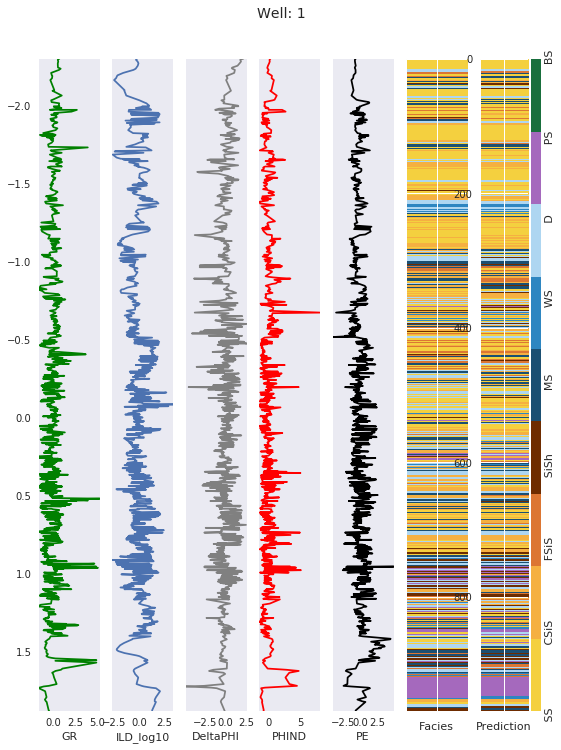

In [31]:
df_test_source = df_test.copy()
df_test_source['FaciesLabels'] = df_test_source.apply(lambda row: label_facies(row, facies_labels), axis=1)
df_test_source['Prediction'] = y_test_classes
compare_facies_plot(df_test_source, 'Prediction', facies_colors)

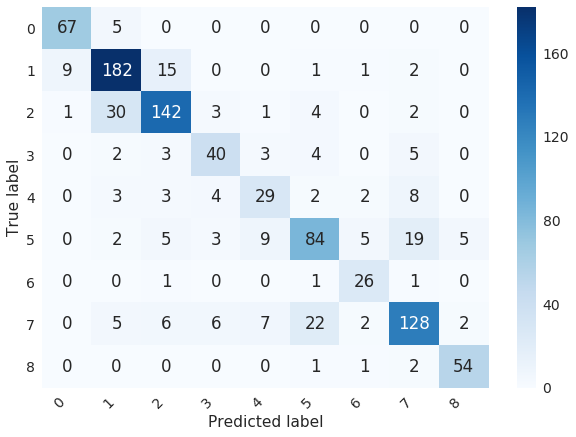

In [60]:
mx_confus = metrics.confusion_matrix(y_test_real, y_test_classes)
# df_confus = pd.DataFrame(mx_confus, range(9), range(9))
print_confusion_matrix(mx_confus, list(range(9)))